In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/ada_multigrid_ppo')

In [2]:
%matplotlib notebook
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
from copy import copy, deepcopy

import gym
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList
from utils.custom_eval_callback import CustomEvalCallback, CustomEvalCallbackParallel
from utils.env_wrappers import StateCoarse, BufferWrapper, EnvCoarseWrapper, StateCoarseMultiGrid
from typing import Callable
from utils.plot_functions import plot_learning
from utils.multigrid_framework_functions import env_wrappers_multigrid, make_env, generate_beta_environement, parallalize_env, multigrid_framework

from model.ressim import Grid
from ressim_env import ResSimEnv_v0, ResSimEnv_v1

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
seed=1
case='case_1_multigrid_adaptive'
data_dir='./data'
log_dir='./data/'+case

In [4]:
os.makedirs(data_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [5]:
with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env_train = pickle.load(input)

# define RL model and callbacks

In [6]:
def generate_model(env_train, seed):
    dummy_env =  generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    dummy_env_parallel = parallalize_env(dummy_env, num_actor=64, seed=seed)
    model = PPO(policy=MlpPolicy,
                env=dummy_env_parallel,
                learning_rate = 3e-6,
                n_steps = 40,
                batch_size = 16,
                n_epochs = 20,
                gamma = 0.99,
                gae_lambda = 0.95,
                clip_range = 0.1,
                clip_range_vf = None,
                ent_coef = 0.001,
                vf_coef = 0.5,
                max_grad_norm = 0.5,
                use_sde= False,
                create_eval_env= False,
                policy_kwargs = dict(net_arch=[150,100,80], log_std_init=-2.9),
                verbose = 1,
                target_kl = 0.05,
                seed = seed,
                device = "auto")
    return model

def generate_callback(env_train, best_model_save_path, log_path, eval_freq):
    dummy_env = generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    callback = CustomEvalCallbackParallel(dummy_env, 
                                          best_model_save_path=best_model_save_path, 
                                          n_eval_episodes=1,
                                          log_path=log_path, 
                                          eval_freq=eval_freq)
    return callback

# multigrid framework

Using cuda device
seed 1: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 15 x 15


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f8dbf6f2a58> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f8dbf6e3470>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.59 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5        |
|    mean_reward     | 0.594    |
| time/              |          |
|    fps             | 176      |
|    iterations      | 1        |
|    time_elapsed    | 14       |
|    total_timesteps | 2560     |
---------------------------------
policy iteration runtime: 43 seconds

Total episode rollouts: 512

Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.597       |
| time/                   |             |
|    fps                  | 213         |
|    iterations           | 1           |
|    time_elapsed         | 11          |
|    total_timesteps      | 2560        |
| t

policy iteration runtime: 34 seconds

Total episode rollouts: 4608

Eval num_timesteps=2560, episode_reward=0.61 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.614       |
| time/                   |             |
|    fps                  | 205         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008558616 |
|    clip_fraction        | 0.331       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.785       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0711      |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0256     |
|    std                  | 

policy iteration runtime: 34 seconds

Total episode rollouts: 8704

Eval num_timesteps=2560, episode_reward=0.64 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.638       |
| time/                   |             |
|    fps                  | 210         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009073767 |
|    clip_fraction        | 0.344       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.85        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0319      |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0259     |
|    std                  | 

policy iteration runtime: 42 seconds

Total episode rollouts: 12800

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.655        |
| time/                   |              |
|    fps                  | 204          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0019960166 |
|    clip_fraction        | 0.345        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.864        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0468       |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.0268      |
|    std

policy iteration runtime: 43 seconds

Total episode rollouts: 16896

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.661      |
| time/                   |            |
|    fps                  | 209        |
|    iterations           | 1          |
|    time_elapsed         | 12         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00624949 |
|    clip_fraction        | 0.347      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.883      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0381     |
|    n_updates            | 660        |
|    policy_gradient_loss | -0.0278    |
|    std                  | 0.0551     |
|    value_loss           |

policy iteration runtime: 34 seconds

Total episode rollouts: 20992

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.669        |
| time/                   |              |
|    fps                  | 212          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0063076317 |
|    clip_fraction        | 0.352        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.889        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0548       |
|    n_updates            | 820          |
|    policy_gradient_loss | -0.0267      |
|    std

policy iteration runtime: 34 seconds

Total episode rollouts: 25088

seed 1: grid fidelity factor 0.5 learning ..
environement grid size (nx x ny ): 30 x 30


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f8dbf6e3470> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f8dbf6f7cf8>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.683        |
| time/                   |              |
|    fps                  | 160          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0042487443 |
|    clip_fraction        | 0.347        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.906        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0587       |
|    n_updates            | 980          |
|    policy_gradient_loss | -0.0264      |
|    std                  | 0.0551       |
|    value_loss           | 0.0031

policy iteration runtime: 38 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.684       |
| time/                   |             |
|    fps                  | 166         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005322394 |
|    clip_fraction        | 0.36        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.88        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0361      |
|    n_updates            | 1140        |
|    policy_gradient_loss | -0.0305     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 37 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.686      |
| time/                   |            |
|    fps                  | 166        |
|    iterations           | 1          |
|    time_elapsed         | 15         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00399805 |
|    clip_fraction        | 0.356      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.894      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0317     |
|    n_updates            | 1300       |
|    policy_gradient_loss | -0.0293    |
|    std                  | 0.0551     |
|    

policy iteration runtime: 40 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.687        |
| time/                   |              |
|    fps                  | 167          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0075751273 |
|    clip_fraction        | 0.36         |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.892        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0499       |
|    n_updates            | 1460         |
|    policy_gradient_loss | -0.0298      |
|    std                  | 0.

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f8dbc07a048> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f8dbc07a908>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.694        |
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 1            |
|    time_elapsed         | 31           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0057114484 |
|    clip_fraction        | 0.362        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.893        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0432       |
|    n_updates            | 1500         |
|    policy_gradient_loss | -0.0293      |
|    std                  | 0.0551       |
|    value_loss           | 0.0036

policy iteration runtime: 54 seconds

Total episode rollouts: 42496

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.695       |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 1           |
|    time_elapsed         | 29          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.010409528 |
|    clip_fraction        | 0.36        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.836       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0689      |
|    n_updates            | 1660        |
|    policy_gradient_loss | -0.031      |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 51 seconds

Total episode rollouts: 46592

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.695        |
| time/                   |              |
|    fps                  | 86           |
|    iterations           | 1            |
|    time_elapsed         | 29           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0069876225 |
|    clip_fraction        | 0.348        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.825        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0558       |
|    n_updates            | 1820         |
|    policy_gradient_loss | -0.0296      |
|    std                  | 0.

policy iteration runtime: 51 seconds

Total episode rollouts: 50688

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.696       |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 1           |
|    time_elapsed         | 29          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007618907 |
|    clip_fraction        | 0.36        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.849       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0605      |
|    n_updates            | 1980        |
|    policy_gradient_loss | -0.0301     |
|    std                  | 0.0551      |
|    va

<IPython.core.display.Javascript object>


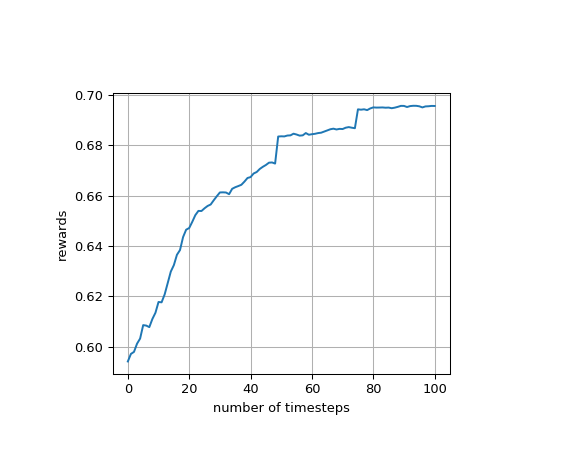

Using cuda device
seed 2: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 15 x 15


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f8d940d2e80> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f8dc134a5f8>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.601       |
| time/                   |             |
|    fps                  | 212         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006365627 |
|    clip_fraction        | 0.357       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.853       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0378      |
|    n_updates            | 2020        |
|    policy_gradient_loss | -0.0295     |
|    std                  | 0.0551      |
|    value_loss           | 0.0051      |
------------

policy iteration runtime: 39 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.62 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.62        |
| time/                   |             |
|    fps                  | 210         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009740907 |
|    clip_fraction        | 0.336       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.799       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0473      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0251     |
|    std                  | 

policy iteration runtime: 40 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.64 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.64         |
| time/                   |              |
|    fps                  | 204          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0072204424 |
|    clip_fraction        | 0.345        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.839        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0607       |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.0261      |
|    std 

policy iteration runtime: 34 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.659        |
| time/                   |              |
|    fps                  | 209          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0075268834 |
|    clip_fraction        | 0.332        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.863        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0676       |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.0254      |
|    std

policy iteration runtime: 42 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.664        |
| time/                   |              |
|    fps                  | 213          |
|    iterations           | 1            |
|    time_elapsed         | 11           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0064074188 |
|    clip_fraction        | 0.347        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.88         |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0431       |
|    n_updates            | 640          |
|    policy_gradient_loss | -0.0274      |
|    std

policy iteration runtime: 34 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.667        |
| time/                   |              |
|    fps                  | 211          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0063805105 |
|    clip_fraction        | 0.337        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.893        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0779       |
|    n_updates            | 800          |
|    policy_gradient_loss | -0.0265      |
|    std                  | 0.

policy iteration runtime: 41 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.672       |
| time/                   |             |
|    fps                  | 211         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004336402 |
|    clip_fraction        | 0.344       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.897       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0759      |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.0275     |
|    std                  |

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f8dc134a5f8> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f8d940c7710>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.685        |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 1            |
|    time_elapsed         | 16           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0064620106 |
|    clip_fraction        | 0.352        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.89         |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0518       |
|    n_updates            | 980          |
|    policy_gradient_loss | -0.0277      |
|    std                  | 0.0551       |
|    value_loss           | 0.0037

policy iteration runtime: 37 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.687       |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004183191 |
|    clip_fraction        | 0.326       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.867       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0978      |
|    n_updates            | 1140        |
|    policy_gradient_loss | -0.0265     |
|    std                  |

policy iteration runtime: 37 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.688       |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.010791781 |
|    clip_fraction        | 0.363       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.882       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0586      |
|    n_updates            | 1300        |
|    policy_gradient_loss | -0.0299     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 38 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.689        |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0075651556 |
|    clip_fraction        | 0.359        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.892        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0507       |
|    n_updates            | 1460         |
|    policy_gradient_loss | -0.0305      |
|    std                  | 0.

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f8dbc1a04a8> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f8d8431f748>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.696       |
| time/                   |             |
|    fps                  | 80          |
|    iterations           | 1           |
|    time_elapsed         | 31          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009452152 |
|    clip_fraction        | 0.372       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.887       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0602      |
|    n_updates            | 1500        |
|    policy_gradient_loss | -0.0307     |
|    std                  | 0.0551      |
|    value_loss           | 0.00394     |
------------

policy iteration runtime: 55 seconds

Total episode rollouts: 42496

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.696        |
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0021544783 |
|    clip_fraction        | 0.361        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.826        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0528       |
|    n_updates            | 1660         |
|    policy_gradient_loss | -0.0309      |
|    std                  | 0.

policy iteration runtime: 52 seconds

Total episode rollouts: 46592

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.695      |
| time/                   |            |
|    fps                  | 84         |
|    iterations           | 1          |
|    time_elapsed         | 30         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00705764 |
|    clip_fraction        | 0.367      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.828      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0472     |
|    n_updates            | 1820       |
|    policy_gradient_loss | -0.0311    |
|    std                  | 0.0551     |
|    value_loss           |

policy iteration runtime: 51 seconds

Total episode rollouts: 50688

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.696       |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 1           |
|    time_elapsed         | 29          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005084306 |
|    clip_fraction        | 0.36        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.837       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0443      |
|    n_updates            | 1980        |
|    policy_gradient_loss | -0.0317     |
|    std                  | 0.0551      |
|    va

<IPython.core.display.Javascript object>


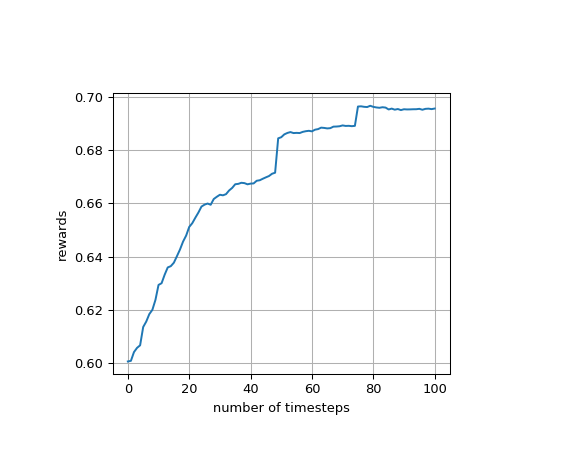

Using cuda device
seed 3: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 15 x 15


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f8d842d9e48> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f8d843020b8>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.599       |
| time/                   |             |
|    fps                  | 210         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008940351 |
|    clip_fraction        | 0.348       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.838       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0681      |
|    n_updates            | 2020        |
|    policy_gradient_loss | -0.0293     |
|    std                  | 0.0551      |
|    value_loss           | 0.00554     |
------------

policy iteration runtime: 40 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.62 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.616       |
| time/                   |             |
|    fps                  | 204         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.011970257 |
|    clip_fraction        | 0.356       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.791       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0357      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0254     |
|    std                  | 

policy iteration runtime: 34 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.63 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.629        |
| time/                   |              |
|    fps                  | 203          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0067400276 |
|    clip_fraction        | 0.334        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.858        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0621       |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.0246      |
|    std 

policy iteration runtime: 36 seconds

Total episode rollouts: 12800

Eval num_timesteps=2560, episode_reward=0.65 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.646      |
| time/                   |            |
|    fps                  | 207        |
|    iterations           | 1          |
|    time_elapsed         | 12         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.01218692 |
|    clip_fraction        | 0.338      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.883      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0854     |
|    n_updates            | 500        |
|    policy_gradient_loss | -0.0246    |
|    std                  | 0.0551     |
|    

policy iteration runtime: 38 seconds

Total episode rollouts: 16896

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.659       |
| time/                   |             |
|    fps                  | 206         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007673341 |
|    clip_fraction        | 0.351       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.906       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0606      |
|    n_updates            | 660         |
|    policy_gradient_loss | -0.0272     |
|    std                  |

policy iteration runtime: 33 seconds

Total episode rollouts: 20992

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.666       |
| time/                   |             |
|    fps                  | 207         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007347724 |
|    clip_fraction        | 0.35        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.9         |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0561      |
|    n_updates            | 820         |
|    policy_gradient_loss | -0.027      |
|    std                  |

policy iteration runtime: 41 seconds

Total episode rollouts: 25088

seed 3: grid fidelity factor 0.5 learning ..
environement grid size (nx x ny ): 30 x 30


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f8dbf6f2f28> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f8d842c5160>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.681       |
| time/                   |             |
|    fps                  | 158         |
|    iterations           | 1           |
|    time_elapsed         | 16          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006482959 |
|    clip_fraction        | 0.352       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.911       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0613      |
|    n_updates            | 980         |
|    policy_gradient_loss | -0.0269     |
|    std                  | 0.0551      |
|    value_loss           | 0.00311     |
------------

policy iteration runtime: 36 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.684       |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007733971 |
|    clip_fraction        | 0.352       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.7        |
|    explained_variance   | 0.882       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0439      |
|    n_updates            | 1140        |
|    policy_gradient_loss | -0.0294     |
|    std                  |

policy iteration runtime: 36 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.686        |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0048668953 |
|    clip_fraction        | 0.366        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.899        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0555       |
|    n_updates            | 1300         |
|    policy_gradient_loss | -0.0293      |
|    std

policy iteration runtime: 41 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.687        |
| time/                   |              |
|    fps                  | 165          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0031028837 |
|    clip_fraction        | 0.352        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.899        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0542       |
|    n_updates            | 1460         |
|    policy_gradient_loss | -0.0277      |
|    std

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f8d940e3cc0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f8dc134aa90>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.696       |
| time/                   |             |
|    fps                  | 80          |
|    iterations           | 1           |
|    time_elapsed         | 31          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.003141269 |
|    clip_fraction        | 0.363       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.9         |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0774      |
|    n_updates            | 1500        |
|    policy_gradient_loss | -0.0289     |
|    std                  | 0.0551      |
|    value_loss           | 0.00357     |
------------

policy iteration runtime: 51 seconds

Total episode rollouts: 42496

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.697       |
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 1           |
|    time_elapsed         | 30          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008654761 |
|    clip_fraction        | 0.339       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.846       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0829      |
|    n_updates            | 1660        |
|    policy_gradient_loss | -0.0279     |
|    std                  |

policy iteration runtime: 49 seconds

Total episode rollouts: 46592

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.698        |
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0060277134 |
|    clip_fraction        | 0.359        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.855        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0886       |
|    n_updates            | 1820         |
|    policy_gradient_loss | -0.03        |
|    std

policy iteration runtime: 57 seconds

Total episode rollouts: 50688

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.698        |
| time/                   |              |
|    fps                  | 83           |
|    iterations           | 1            |
|    time_elapsed         | 30           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0049493224 |
|    clip_fraction        | 0.343        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.868        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0694       |
|    n_updates            | 1980         |
|    policy_gradient_loss | -0.0285      |
|    std                  | 0.

<IPython.core.display.Javascript object>


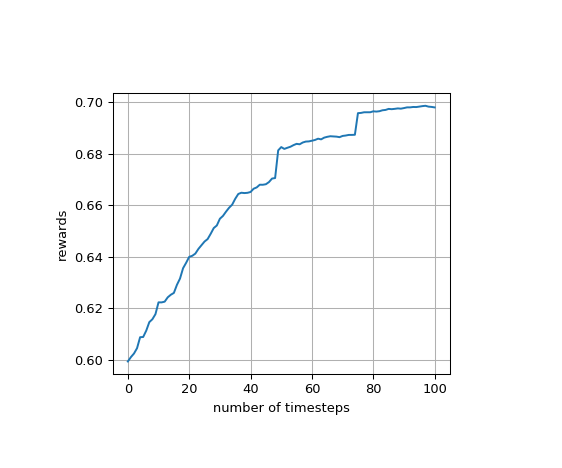

In [7]:
for seed in range(1,4):
    model = multigrid_framework(env_train, 
                                generate_model,
                                generate_callback, 
                                delta_pcent=0.2, 
                                n=25,
                                grid_fidelity_factor_array =[0.25, 0.5, 1.0],
                                episode_limit_array=[25000, 25000, 25000], 
                                log_dir=log_dir,
                                seed=seed)